In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

In [2]:
# !gdown 1fQzxRFnKSWJ1gSHzBUqr8Xo9SMFPeZAZ
# !unzip chest_xray_balanced.zip

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Reading dataset
local_path = "C:/Users/Sandil/OneDrive/Documents/University/Liverpool/(6) Deep Learning/X_ray_Pneumonia CNN/chest_xray_balanced/chest_xray_balanced"
# gdrive_path = "chest_xray_balanced"

all_data = tf.keras.utils.image_dataset_from_directory(
    directory=local_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    seed=1991,
    shuffle=True,
    color_mode='grayscale',
    image_size=(256, 256)
)
class_names = all_data.class_names

DATASET_SIZE = all_data.cardinality().numpy()

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

training_dataset = all_data.take(train_size)                    # [###################################...............]
validation_dataset = all_data.skip(train_size).take(val_size)   # [...................................#########......]
test_dataset = all_data.skip(train_size+val_size)               # [............................................######]

print(all_data.cardinality().numpy(),
      training_dataset.cardinality().numpy(),
      validation_dataset.cardinality().numpy(),
      test_dataset.cardinality().numpy())

training_dataset.class_names = class_names
validation_dataset.class_names = class_names
test_dataset.class_names = class_names

Found 3166 files belonging to 2 classes.
99 69 19 11


In [5]:
# Augment data and add back to dataset

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal", seed=42),
    RandomFlip("vertical", seed=42),
    RandomRotation(0.2, seed=42),
    RandomZoom(0.05, seed=42),
])

# augmented_data = all_data

# for i in range(1):
#     all_data_augmented = augmented_data.map(lambda x, y: (data_augmentation(x), y))
#     # augmented_pneumonia_cases = pneumonia_cases.map(lambda x, y: (data_augmentation(x), y))
#     augmented_data = augmented_data.concatenate(all_data_augmented)
#     # full_ds = full_ds.concatenate(augmented_pneumonia_cases)

# DATASET_SIZE = augmented_data.cardinality().numpy()

# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.2 * DATASET_SIZE)
# test_size = int(0.1 * DATASET_SIZE)

# augmented_data = augmented_data.shuffle(buffer_size=1000, seed=42)

# aug_training_dataset = augmented_data.take(train_size)                    # [###################################...............]
# aug_validation_dataset = augmented_data.skip(train_size).take(val_size)   # [...................................#########......]
# aug_test_dataset = augmented_data.skip(train_size+val_size)               # [............................................######]

aug_training_dataset = training_dataset
aug_validation_dataset = validation_dataset
aug_test_dataset = test_dataset

for i in range(2):
    train_augmented = training_dataset.map(lambda x, y: (data_augmentation(x), y))
    test_augmented = test_dataset.map(lambda x, y: (data_augmentation(x), y))
    val_augmented = validation_dataset.map(lambda x, y: (data_augmentation(x), y))
    aug_training_dataset = aug_training_dataset.concatenate(train_augmented)
    aug_test_dataset = aug_test_dataset.concatenate(test_augmented)
    aug_validation_dataset = aug_validation_dataset.concatenate(val_augmented)

aug_training_dataset = aug_training_dataset.shuffle(buffer_size=1000, seed=42)
aug_validation_dataset = aug_validation_dataset.shuffle(buffer_size=1000, seed=42)
aug_test_dataset = aug_test_dataset.shuffle(buffer_size=1000, seed=42)

print(aug_training_dataset.cardinality().numpy(),
      aug_validation_dataset.cardinality().numpy(),
      aug_test_dataset.cardinality().numpy())

aug_training_dataset.class_names = class_names
aug_validation_dataset.class_names = class_names
aug_test_dataset.class_names = class_names

207 57 33


In [6]:
# Define visualisation function
def visualise(dataset, rows=3, columns=0):

    if columns == 0:
        columns = rows

    plt.figure(figsize = (10, 10))
    for images, labels in dataset.take(1):
        for i in range(1, rows * columns +1):
            plt.subplot(rows, columns, i)
            plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap='gray')
            plt.title(dataset.class_names[labels[i].numpy().argmax()] + ' ' + str(labels[i].numpy().argmax()))
            plt.axis('off')

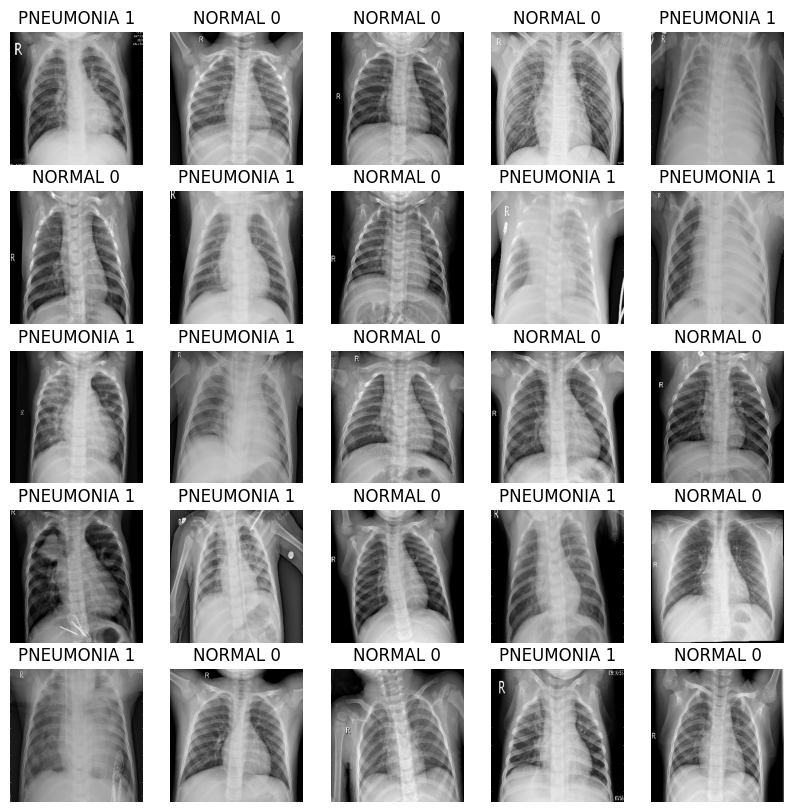

In [7]:
visualise(dataset=training_dataset, rows=5, columns=5)

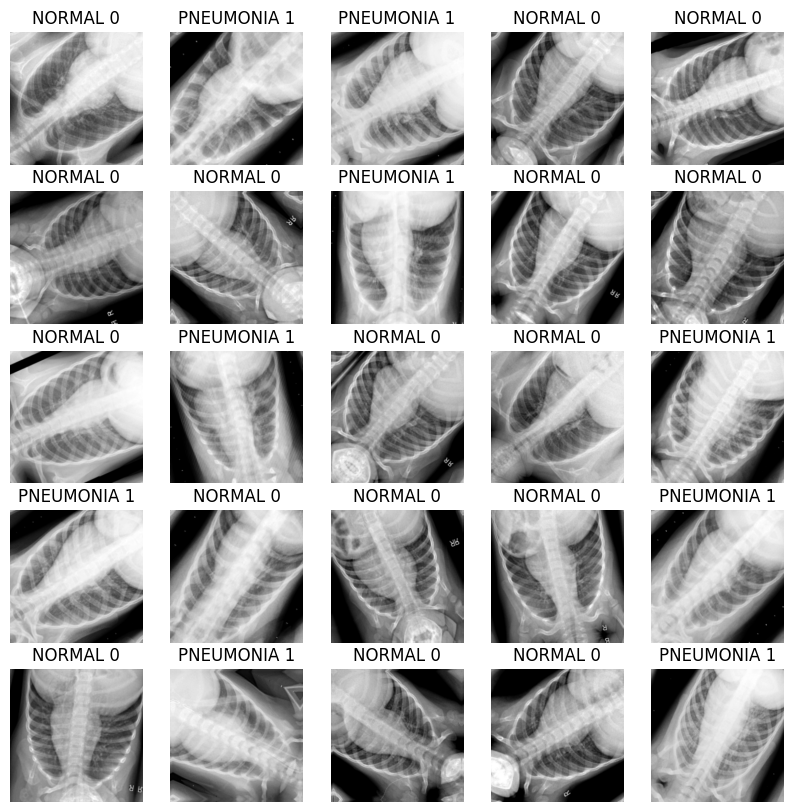

In [8]:
visualise(dataset=aug_training_dataset, rows=5, columns=5)

In [9]:
## Callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
early_stopping_lenient = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)

In [10]:
def visualise_performance(training_output):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    plt.ylim([0, 1.0])
    ax = ax.ravel()

    for i, met in enumerate(['categorical_accuracy', 'loss']):
        ax[i].plot(training_output.history[met])
        ax[i].plot(training_output.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

In [11]:
# Create model
relu_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid),
], name='relu_model')


relu_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [12]:
# Fetch data, and train the model
relu_output = relu_model.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 9s 59ms/step - loss: 0.3801 - categorical_accuracy: 0.8188 - val_loss: 0.1699 - val_categorical_accuracy: 0.9424 - lr: 0.0010
Epoch 2/32
18/69 [======>.......................] - ETA: 1s - loss: 0.1773 - categorical_accuracy: 0.9306

KeyboardInterrupt: 

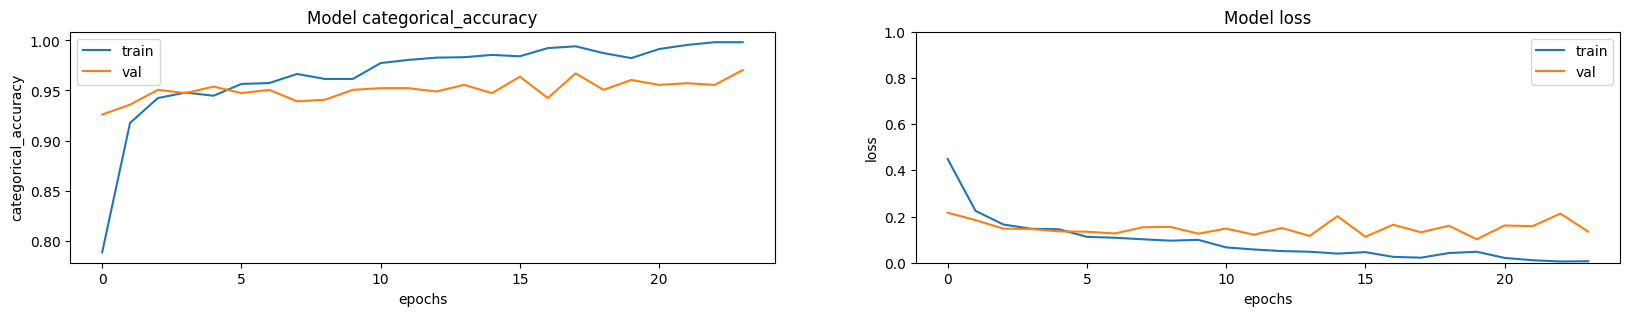

In [ ]:
visualise_performance(relu_output)

In [ ]:
# Create model
aug_relu_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid),
], name='aug_relu_model')


aug_relu_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
# Fetch data, and train the model
aug_relu_output = aug_relu_model.fit(aug_training_dataset, validation_data=aug_validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping_lenient, reduce_lr])

Epoch 1/32
207/207 [==============================] - 54s 130ms/step - loss: 0.4764 - categorical_accuracy: 0.7621 - val_loss: 0.2664 - val_categorical_accuracy: 0.8904 - lr: 0.0010
Epoch 2/32
207/207 [==============================] - 53s 128ms/step - loss: 0.2832 - categorical_accuracy: 0.8889 - val_loss: 0.2869 - val_categorical_accuracy: 0.8799 - lr: 0.0010
Epoch 3/32
207/207 [==============================] - 53s 128ms/step - loss: 0.2595 - categorical_accuracy: 0.9016 - val_loss: 0.2248 - val_categorical_accuracy: 0.9079 - lr: 0.0010
Epoch 4/32
207/207 [==============================] - 54s 129ms/step - loss: 0.2278 - categorical_accuracy: 0.9194 - val_loss: 0.2078 - val_categorical_accuracy: 0.9216 - lr: 0.0010
Epoch 5/32
207/207 [==============================] - 53s 127ms/step - loss: 0.2170 - categorical_accuracy: 0.9198 - val_loss: 0.1848 - val_categorical_accuracy: 0.9315 - lr: 0.0010
Epoch 6/32
207/207 [==============================] - 53s 127ms/step - loss: 0.2007 - cate

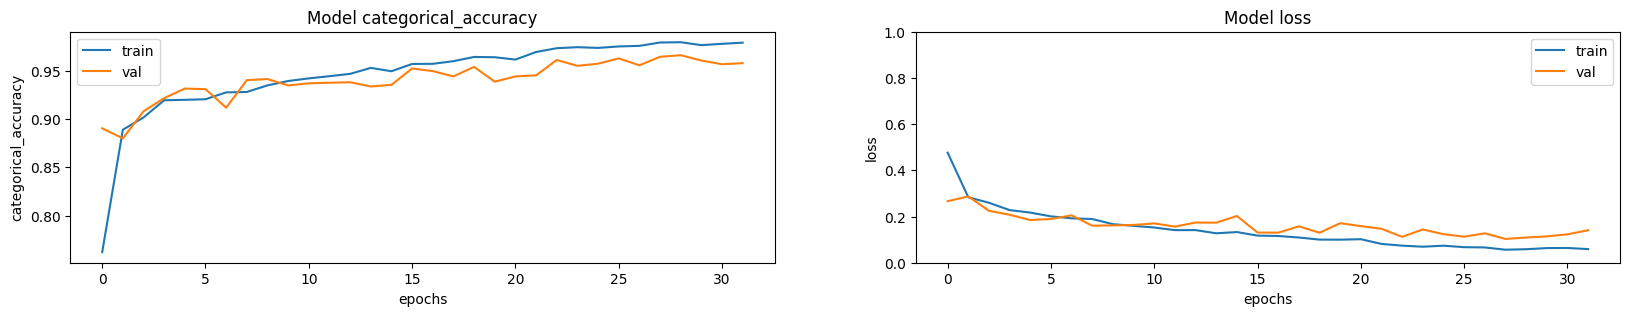

In [ ]:
visualise_performance(aug_relu_output)

In [ ]:
# Create model
relu_model_l1 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid),
], name='relu_model_l1')


relu_model_l1.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
# Fetch data, and train the model
relu_l1_output = relu_model_l1.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 12s 162ms/step - loss: 7.8385 - categorical_accuracy: 0.6513 - val_loss: 2.4332 - val_categorical_accuracy: 0.8339 - lr: 0.0010
Epoch 2/32
69/69 [==============================] - 11s 158ms/step - loss: 0.9943 - categorical_accuracy: 0.8573 - val_loss: 0.4687 - val_categorical_accuracy: 0.9030 - lr: 0.0010
Epoch 3/32
69/69 [==============================] - 11s 160ms/step - loss: 0.4582 - categorical_accuracy: 0.8967 - val_loss: 0.4136 - val_categorical_accuracy: 0.9062 - lr: 0.0010
Epoch 4/32
69/69 [==============================] - 11s 155ms/step - loss: 0.4042 - categorical_accuracy: 0.9062 - val_loss: 0.3849 - val_categorical_accuracy: 0.9046 - lr: 0.0010
Epoch 5/32
69/69 [==============================] - 11s 156ms/step - loss: 0.3948 - categorical_accuracy: 0.8999 - val_loss: 0.3633 - val_categorical_accuracy: 0.9095 - lr: 0.0010
Epoch 6/32
69/69 [==============================] - 11s 156ms/step - loss: 0.3618 - categorical_accu

In [ ]:
# visualise_performance(relu_model_l1.history.history.values())

In [ ]:
# Create model
relu_model_l2 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid),
], name='relu_model_l2')


relu_model_l2.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
# Fetch data, and train the model
relu_l2_output = relu_model_l2.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 12s 159ms/step - loss: 1.0076 - categorical_accuracy: 0.7224 - val_loss: 0.5312 - val_categorical_accuracy: 0.8734 - lr: 0.0010
Epoch 2/32
69/69 [==============================] - 12s 162ms/step - loss: 0.3933 - categorical_accuracy: 0.9103 - val_loss: 0.3204 - val_categorical_accuracy: 0.9293 - lr: 0.0010
Epoch 3/32
69/69 [==============================] - 11s 156ms/step - loss: 0.3208 - categorical_accuracy: 0.9212 - val_loss: 0.2936 - val_categorical_accuracy: 0.9211 - lr: 0.0010
Epoch 4/32
69/69 [==============================] - 12s 161ms/step - loss: 0.2814 - categorical_accuracy: 0.9284 - val_loss: 0.2444 - val_categorical_accuracy: 0.9441 - lr: 0.0010
Epoch 5/32
69/69 [==============================] - 11s 155ms/step - loss: 0.2416 - categorical_accuracy: 0.9384 - val_loss: 0.2786 - val_categorical_accuracy: 0.9243 - lr: 0.0010
Epoch 6/32
69/69 [==============================] - 11s 156ms/step - loss: 0.2284 - categorical_accu

In [ ]:
# visualise_performance(relu_model_l2.history)

In [ ]:
# Create model
tanh_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='tanh_model')

tanh_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
tanh_output = tanh_model.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 12s 162ms/step - loss: 0.5188 - categorical_accuracy: 0.7794 - val_loss: 0.2564 - val_categorical_accuracy: 0.8914 - lr: 0.0010
Epoch 2/32
69/69 [==============================] - 11s 154ms/step - loss: 0.2157 - categorical_accuracy: 0.9049 - val_loss: 0.1931 - val_categorical_accuracy: 0.9227 - lr: 0.0010
Epoch 3/32
69/69 [==============================] - 11s 157ms/step - loss: 0.1734 - categorical_accuracy: 0.9370 - val_loss: 0.1482 - val_categorical_accuracy: 0.9309 - lr: 0.0010
Epoch 4/32
69/69 [==============================] - 11s 160ms/step - loss: 0.1522 - categorical_accuracy: 0.9438 - val_loss: 0.1891 - val_categorical_accuracy: 0.9260 - lr: 0.0010
Epoch 5/32
69/69 [==============================] - 11s 157ms/step - loss: 0.1255 - categorical_accuracy: 0.9534 - val_loss: 0.2018 - val_categorical_accuracy: 0.9178 - lr: 0.0010
Epoch 6/32
69/69 [==============================] - 12s 161ms/step - loss: 0.1041 - categorical_accu

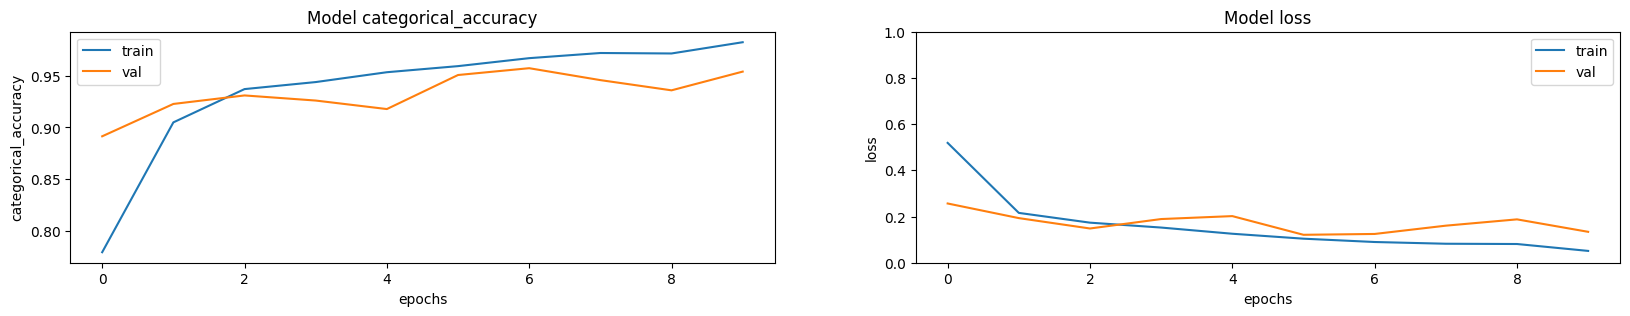

In [ ]:
visualise_performance(tanh_output)

In [ ]:
# Create model
aug_tanh_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='aug_tanh_model')

aug_tanh_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
# Fetch data, and train the model
aug_tanh_output = aug_tanh_model.fit(aug_training_dataset, validation_data=aug_validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping_lenient, reduce_lr])

Epoch 1/32
207/207 [==============================] - 55s 132ms/step - loss: 0.4807 - categorical_accuracy: 0.7742 - val_loss: 0.3101 - val_categorical_accuracy: 0.8805 - lr: 0.0010
Epoch 2/32
207/207 [==============================] - 54s 133ms/step - loss: 0.3035 - categorical_accuracy: 0.8758 - val_loss: 0.2650 - val_categorical_accuracy: 0.8827 - lr: 0.0010
Epoch 3/32
207/207 [==============================] - 54s 132ms/step - loss: 0.2616 - categorical_accuracy: 0.8969 - val_loss: 0.2394 - val_categorical_accuracy: 0.9052 - lr: 0.0010
Epoch 4/32
207/207 [==============================] - 55s 134ms/step - loss: 0.2285 - categorical_accuracy: 0.9102 - val_loss: 0.2176 - val_categorical_accuracy: 0.9205 - lr: 0.0010
Epoch 5/32
207/207 [==============================] - 55s 137ms/step - loss: 0.2175 - categorical_accuracy: 0.9159 - val_loss: 0.2151 - val_categorical_accuracy: 0.9145 - lr: 0.0010
Epoch 6/32
207/207 [==============================] - 54s 131ms/step - loss: 0.2132 - cate

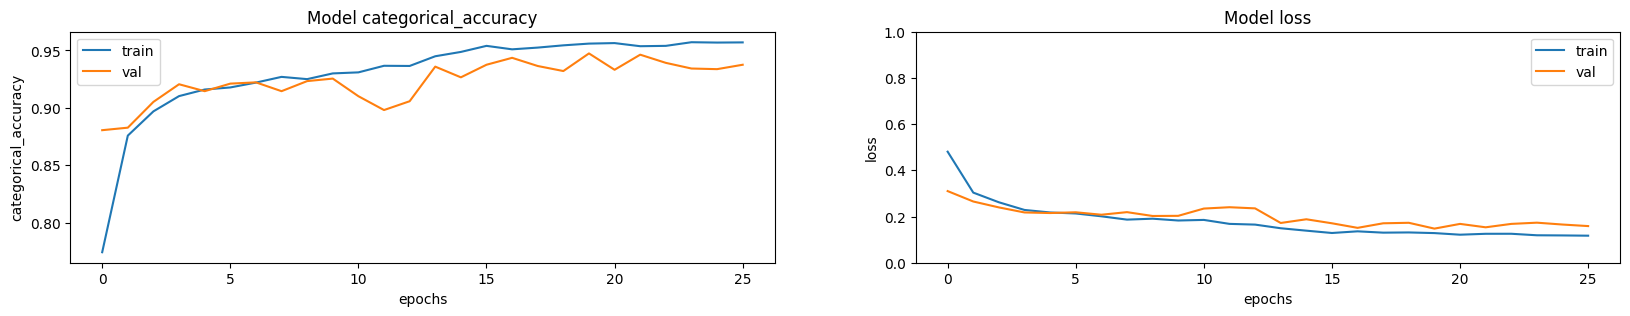

In [ ]:
visualise_performance(aug_tanh_output)

In [ ]:
# Create model
tanh_model_l1 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='tanh_model_l1')

tanh_model_l1.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
tanh_l1_output = tanh_model_l1.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 12s 158ms/step - loss: 11.5494 - categorical_accuracy: 0.7844 - val_loss: 8.1727 - val_categorical_accuracy: 0.8174 - lr: 0.0010
Epoch 2/32
69/69 [==============================] - 11s 154ms/step - loss: 5.6137 - categorical_accuracy: 0.8872 - val_loss: 3.5924 - val_categorical_accuracy: 0.8997 - lr: 0.0010
Epoch 3/32
69/69 [==============================] - 11s 159ms/step - loss: 2.5589 - categorical_accuracy: 0.8954 - val_loss: 1.7199 - val_categorical_accuracy: 0.9095 - lr: 0.0010
Epoch 4/32
69/69 [==============================] - 11s 158ms/step - loss: 1.3394 - categorical_accuracy: 0.8813 - val_loss: 0.9833 - val_categorical_accuracy: 0.9046 - lr: 0.0010
Epoch 5/32
69/69 [==============================] - 11s 156ms/step - loss: 0.8268 - categorical_accuracy: 0.8981 - val_loss: 0.6742 - val_categorical_accuracy: 0.9095 - lr: 0.0010
Epoch 6/32
69/69 [==============================] - 11s 160ms/step - loss: 0.6127 - categorical_acc

In [ ]:
# visualise_performance(tanh_l1_output.history)

In [ ]:
# Create model
tanh_model_l2 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.tanh, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='tanh_model_l2')

tanh_model_l2.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
tanh_l2_output = tanh_model_l2.fit(training_dataset, validation_data=validation_dataset, epochs=32, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/32
69/69 [==============================] - 12s 160ms/step - loss: 1.3936 - categorical_accuracy: 0.7998 - val_loss: 1.0973 - val_categorical_accuracy: 0.9030 - lr: 0.0010
Epoch 2/32
69/69 [==============================] - 11s 154ms/step - loss: 1.0411 - categorical_accuracy: 0.9058 - val_loss: 0.9338 - val_categorical_accuracy: 0.9326 - lr: 0.0010
Epoch 3/32
69/69 [==============================] - 12s 162ms/step - loss: 0.8929 - categorical_accuracy: 0.9167 - val_loss: 0.8211 - val_categorical_accuracy: 0.9342 - lr: 0.0010
Epoch 4/32
69/69 [==============================] - 12s 169ms/step - loss: 0.7570 - categorical_accuracy: 0.9370 - val_loss: 0.7417 - val_categorical_accuracy: 0.9227 - lr: 0.0010
Epoch 5/32
69/69 [==============================] - 11s 159ms/step - loss: 0.6486 - categorical_accuracy: 0.9447 - val_loss: 0.6174 - val_categorical_accuracy: 0.9441 - lr: 0.0010
Epoch 6/32
69/69 [==============================] - 12s 159ms/step - loss: 0.5587 - categorical_accu

In [ ]:
# visualise_performance(tanh_l2_output.history)

In [ ]:
# Create model
regularised_relu_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    tf.keras.layers.Dropout(rate=0.05),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='regularised_relu_model')

regularised_relu_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
regularised_relu_output = regularised_relu_model.fit(training_dataset, validation_data=validation_dataset, epochs=64, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/64
69/69 [==============================] - 13s 165ms/step - loss: 0.5849 - categorical_accuracy: 0.6694 - val_loss: 0.4205 - val_categorical_accuracy: 0.8684 - lr: 0.0010
Epoch 2/64
69/69 [==============================] - 12s 162ms/step - loss: 0.3143 - categorical_accuracy: 0.8723 - val_loss: 0.3404 - val_categorical_accuracy: 0.8964 - lr: 0.0010
Epoch 3/64
69/69 [==============================] - 12s 163ms/step - loss: 0.2242 - categorical_accuracy: 0.9149 - val_loss: 0.4577 - val_categorical_accuracy: 0.8651 - lr: 0.0010
Epoch 4/64
69/69 [==============================] - 12s 162ms/step - loss: 0.1875 - categorical_accuracy: 0.9284 - val_loss: 0.2437 - val_categorical_accuracy: 0.9260 - lr: 0.0010
Epoch 5/64
69/69 [==============================] - 12s 166ms/step - loss: 0.1750 - categorical_accuracy: 0.9357 - val_loss: 0.2444 - val_categorical_accuracy: 0.9276 - lr: 0.0010
Epoch 6/64
69/69 [==============================] - 11s 159ms/step - loss: 0.1584 - categorical_accu

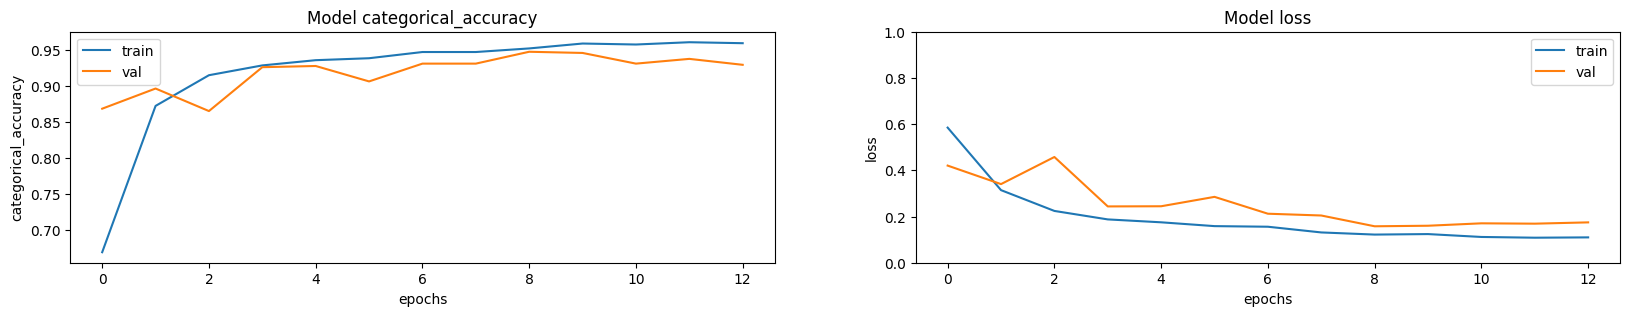

In [ ]:
visualise_performance(regularised_relu_output)

In [ ]:
# Create model
aug_regularised_relu_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    tf.keras.layers.Dropout(rate=0.05),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='aug_regularised_relu_model')

aug_regularised_relu_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
aug_regularised_relu_output = aug_regularised_relu_model.fit(aug_training_dataset, validation_data=aug_validation_dataset, epochs=64, use_multiprocessing=True, callbacks=[early_stopping_lenient, reduce_lr])

Epoch 1/64
207/207 [==============================] - 55s 131ms/step - loss: 0.4947 - categorical_accuracy: 0.7480 - val_loss: 0.6034 - val_categorical_accuracy: 0.7643 - lr: 0.0010
Epoch 2/64
207/207 [==============================] - 54s 128ms/step - loss: 0.3218 - categorical_accuracy: 0.8694 - val_loss: 0.5002 - val_categorical_accuracy: 0.8662 - lr: 0.0010
Epoch 3/64
207/207 [==============================] - 53s 128ms/step - loss: 0.2897 - categorical_accuracy: 0.8865 - val_loss: 0.4122 - val_categorical_accuracy: 0.8953 - lr: 0.0010
Epoch 4/64
207/207 [==============================] - 53s 128ms/step - loss: 0.2537 - categorical_accuracy: 0.9014 - val_loss: 0.2725 - val_categorical_accuracy: 0.8997 - lr: 0.0010
Epoch 5/64
207/207 [==============================] - 53s 127ms/step - loss: 0.2349 - categorical_accuracy: 0.9105 - val_loss: 0.2830 - val_categorical_accuracy: 0.8887 - lr: 0.0010
Epoch 6/64
207/207 [==============================] - 54s 129ms/step - loss: 0.2273 - cate

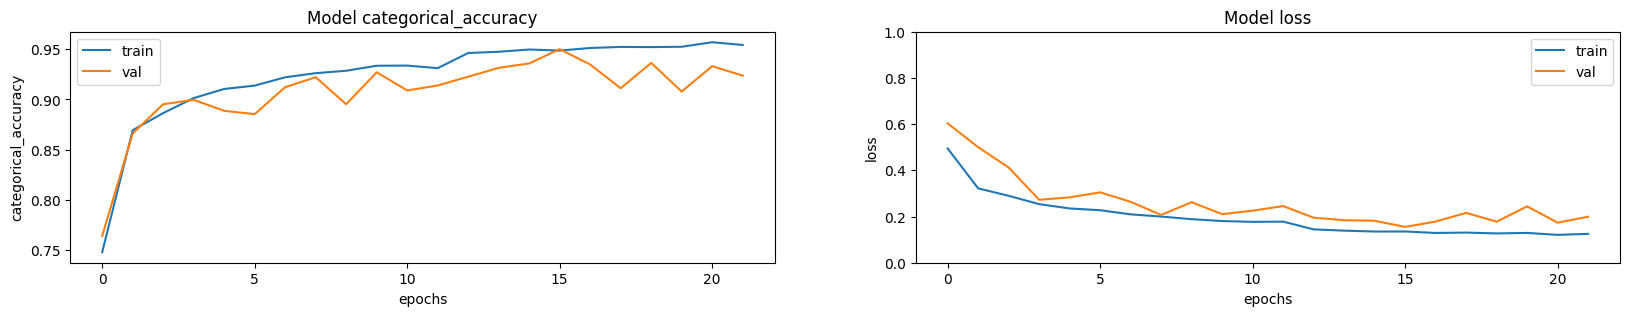

In [ ]:
visualise_performance(aug_regularised_relu_output)

In [ ]:
# Create model
regularised_tanh_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    tf.keras.layers.Dropout(rate=0.05),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='regularised_tanh_model')

regularised_tanh_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
regularised_tanh_output = regularised_tanh_model.fit(training_dataset, validation_data=validation_dataset, epochs=64, use_multiprocessing=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/64
69/69 [==============================] - 13s 174ms/step - loss: 0.5487 - categorical_accuracy: 0.7255 - val_loss: 0.5092 - val_categorical_accuracy: 0.8174 - lr: 0.0010
Epoch 2/64
69/69 [==============================] - 12s 161ms/step - loss: 0.3135 - categorical_accuracy: 0.8741 - val_loss: 0.3586 - val_categorical_accuracy: 0.9062 - lr: 0.0010
Epoch 3/64
69/69 [==============================] - 12s 168ms/step - loss: 0.2099 - categorical_accuracy: 0.9167 - val_loss: 0.3205 - val_categorical_accuracy: 0.8947 - lr: 0.0010
Epoch 4/64
69/69 [==============================] - 12s 162ms/step - loss: 0.1900 - categorical_accuracy: 0.9266 - val_loss: 0.3063 - val_categorical_accuracy: 0.9112 - lr: 0.0010
Epoch 5/64
69/69 [==============================] - 11s 159ms/step - loss: 0.1768 - categorical_accuracy: 0.9307 - val_loss: 0.3197 - val_categorical_accuracy: 0.9293 - lr: 0.0010
Epoch 6/64
69/69 [==============================] - 12s 167ms/step - loss: 0.1563 - categorical_accu

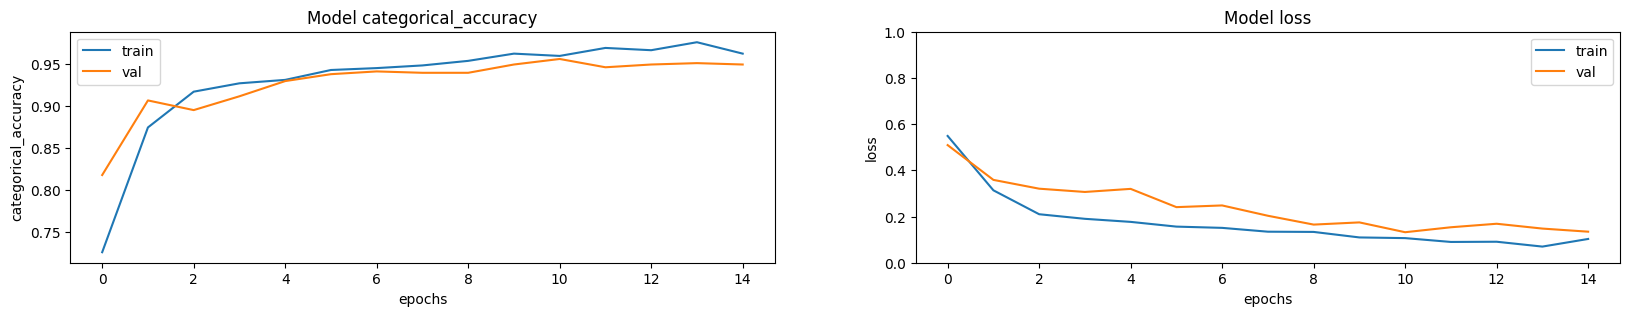

In [ ]:
visualise_performance(regularised_tanh_output)

In [ ]:
# Create model
aug_regularised_tanh_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    # Regularisation on the input
    tf.keras.layers.Dropout(rate=0.05),
    # Feature learning: 4 Layers of convolution
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),  # Prepare for classification
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax),
], name='aug_regularised_tanh_model')

aug_regularised_tanh_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
aug_regularised_tanh_output = aug_regularised_tanh_model.fit(aug_training_dataset, validation_data=aug_validation_dataset, epochs=64, use_multiprocessing=True, callbacks=[early_stopping_lenient, reduce_lr])

Epoch 1/64
207/207 [==============================] - 56s 131ms/step - loss: 0.5542 - categorical_accuracy: 0.7203 - val_loss: 0.5230 - val_categorical_accuracy: 0.7632 - lr: 0.0010
Epoch 2/64
207/207 [==============================] - 54s 128ms/step - loss: 0.3370 - categorical_accuracy: 0.8634 - val_loss: 0.3136 - val_categorical_accuracy: 0.9030 - lr: 0.0010
Epoch 3/64
207/207 [==============================] - 54s 129ms/step - loss: 0.2679 - categorical_accuracy: 0.8927 - val_loss: 0.3517 - val_categorical_accuracy: 0.8816 - lr: 0.0010
Epoch 4/64
207/207 [==============================] - 54s 128ms/step - loss: 0.2513 - categorical_accuracy: 0.8999 - val_loss: 0.2608 - val_categorical_accuracy: 0.9139 - lr: 0.0010
Epoch 5/64
207/207 [==============================] - 54s 128ms/step - loss: 0.2259 - categorical_accuracy: 0.9141 - val_loss: 0.2899 - val_categorical_accuracy: 0.8843 - lr: 0.0010
Epoch 6/64
207/207 [==============================] - 54s 127ms/step - loss: 0.2120 - cate

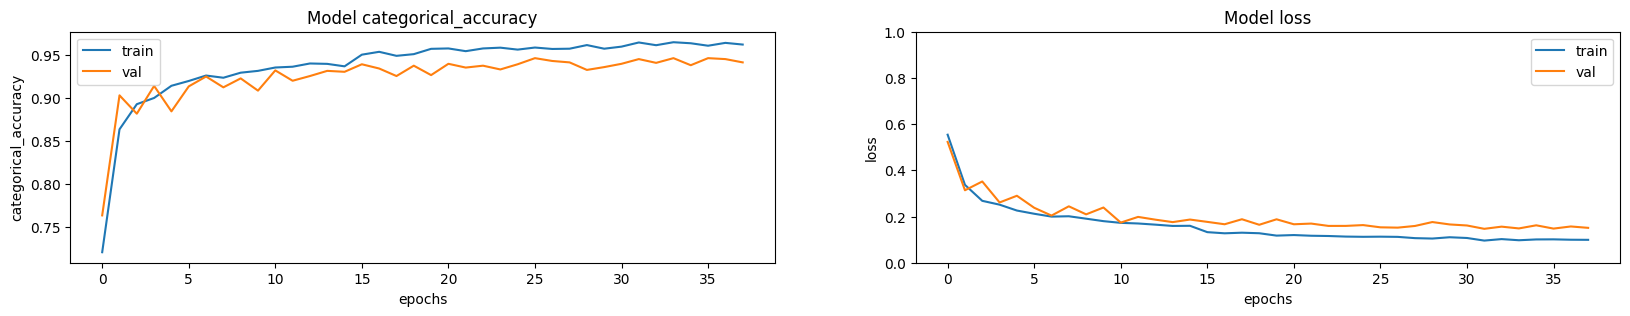

In [ ]:
visualise_performance(aug_regularised_tanh_output)

In [ ]:
def visualise_classification(dataset, class_names, model, rows=3, columns=0):

    if columns == 0:
        columns = rows

    plt.figure(figsize = (10, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(1, rows * columns +1):
            plt.subplot(rows, columns, i)
            plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap='gray')
            prediction = 'C'
            if labels[i].numpy().argmax() != predictions[i].argmax() :
                prediction = 'I'
            plt.title('{}/{}'.format(prediction, class_names[labels[i].numpy().argmax()]))
            plt.axis('off')

In [ ]:
# # Evaluate the model
# visualise_classification(test_dataset.take(1), test_dataset.class_names, regularised_model, 5,5)
# visualise_classification(test_dataset.skip(1), test_dataset.class_names, regularised_model, 5,5)
# visualise_classification(test_dataset.skip(2), test_dataset.class_names, regularised_model, 5,5)

In [ ]:
# Manually measure actual accuracy
import itertools

def update_df(metrics, df):
    if metrics[-1] == "test":
        df.loc[len(df), "Model"] = metrics[0] + "(test)"
        df.loc[len(df)-1, "Dataset"] = "Test"
    elif metrics[-1] == "train":
        df.loc[len(df), "Model"] = metrics[0] + "(train)"
        df.loc[len(df)-1, "Dataset"] = "Train"
    elif metrics[-1] == "aug_train":
        df.loc[len(df), "Model"] = metrics[0] + "(aug_train)"
        df.loc[len(df)-1, "Dataset"] = "Augmented Train"
    elif metrics[-1] == "aug_test":
        df.loc[len(df), "Model"] = metrics[0] + "(aug_test)"
        df.loc[len(df)-1, "Dataset"] = "Augmented Test"
    df.loc[len(df)-1, "Total Cases"] = metrics[1]
    df.loc[len(df)-1, "True Pos"] = metrics[2]
    df.loc[len(df)-1, "True Neg"] = metrics[3]
    df.loc[len(df)-1, "False Pos"] = metrics[4]
    df.loc[len(df)-1, "False Neg"] = metrics[5]
    df.loc[len(df)-1, "Accuracy"] = metrics[6]
    df.loc[len(df)-1, "Precision"] = metrics[7]
    df.loc[len(df)-1, "Recall"] = metrics[8]
    return df

def measure_accuracy(dataset, model, df, dataset_type="test"):
    total = 0
    true_pos = 0
    true_neg = 0
    false_neg = 0
    false_pos = 0
    for images, labels in dataset:
        predictions = model.predict(images, verbose=None)
        for i, p in enumerate(predictions):
            # convert prediction to one-hot encoded
            predicted_class_index = p.argmax()
            actual_class_index = labels[i].numpy().argmax()
            if predicted_class_index == actual_class_index :
                if predicted_class_index == 0:
                    true_neg += 1
                else:
                    true_pos += 1
            elif predicted_class_index == 0:
                false_neg += 1
            else:
                false_pos += 1
            total = total + 1
    accuracy = (true_pos + true_neg) / total
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    metrics = [model.name, total, true_pos, true_neg, false_pos, false_neg, accuracy, precision, recall, dataset_type]
    df = update_df(metrics, df)
    return df



In [ ]:
df = pd.DataFrame()

df = measure_accuracy(test_dataset, relu_model, df)
df = measure_accuracy(training_dataset, relu_model, df, "train")
df = measure_accuracy(aug_training_dataset, aug_relu_model, df, "aug_train")
df = measure_accuracy(aug_test_dataset, aug_relu_model, df, "aug_test")

df = measure_accuracy(test_dataset, regularised_relu_model, df)
df = measure_accuracy(training_dataset, regularised_relu_model, df, "train")
df = measure_accuracy(aug_training_dataset, aug_regularised_relu_model, df, "aug_train")
df = measure_accuracy(aug_test_dataset, aug_regularised_relu_model, df, "aug_test")

df = measure_accuracy(test_dataset, tanh_model, df)
df = measure_accuracy(training_dataset, tanh_model, df, "train")
df = measure_accuracy(aug_training_dataset, aug_tanh_model, df, "aug_train")
df = measure_accuracy(aug_test_dataset, aug_tanh_model, df, "aug_test")

df = measure_accuracy(test_dataset, regularised_tanh_model, df)
df = measure_accuracy(training_dataset, regularised_tanh_model, df, "train")
df = measure_accuracy(aug_training_dataset, aug_regularised_tanh_model, df, "aug_train")
df = measure_accuracy(aug_test_dataset, aug_regularised_tanh_model, df, "aug_test")

df = measure_accuracy(test_dataset, relu_model_l1, df)
df = measure_accuracy(training_dataset, relu_model_l1, df, "train")
df = measure_accuracy(test_dataset, relu_model_l2, df)
df = measure_accuracy(training_dataset, relu_model_l2, df, "train")

df = measure_accuracy(test_dataset, tanh_model_l1, df)
df = measure_accuracy(training_dataset, tanh_model_l1, df, "train")
df = measure_accuracy(test_dataset, tanh_model_l2, df)
df = measure_accuracy(training_dataset, tanh_model_l2, df, "train")


df.head(20)

,Model,Dataset,Total Cases,True Pos,True Neg,False Pos,False Neg,Accuracy,Precision,Recall
0,relu_model(test),Test,350.0,163.0,163.0,10.0,14.0,0.931429,0.942197,0.920904
1,relu_model(train),Train,2208.0,1072.0,1103.0,0.0,33.0,0.985054,1.000000,0.970136
2,aug_relu_model(aug_train),Augmented Train,6624.0,3258.0,3236.0,70.0,60.0,0.980374,0.978966,0.981917
3,aug_relu_model(aug_test),Augmented Test,1050.0,530.0,469.0,36.0,15.0,0.951429,0.936396,0.972477
4,regularised_relu_model(test),Test,350.0,169.0,150.0,12.0,19.0,0.911429,0.933702,0.898936
5,regularised_relu_model(train),Train,2208.0,1041.0,1073.0,23.0,71.0,0.957428,0.978383,0.936151
6,aug_regularised_relu_model(aug_train),Augmented Train,6624.0,3139.0,3143.0,175.0,167.0,0.948370,0.947194,0.949486
7,aug_regularised_relu_model(aug_test),Augmented Test,1050.0,517.0,470.0,37.0,26.0,0.940000,0.933213,0.952118
8,tanh_model(test),Test,350.0,166.0,157.0,17.0,10.0,0.922857,0.907104,0.943182
9,tanh_model(train),Train,2208.0,1071.0,1069.0,40.0,28.0,0.969203,0.963996,0.974522


In [ ]:
df.to_csv('C:/Users/Sandil/OneDrive/Documents/University/Liverpool/(6) Deep Learning/X_ray_Pneumonia CNN/results.csv', index=False)
# df = pd.read_csv('results.csv')

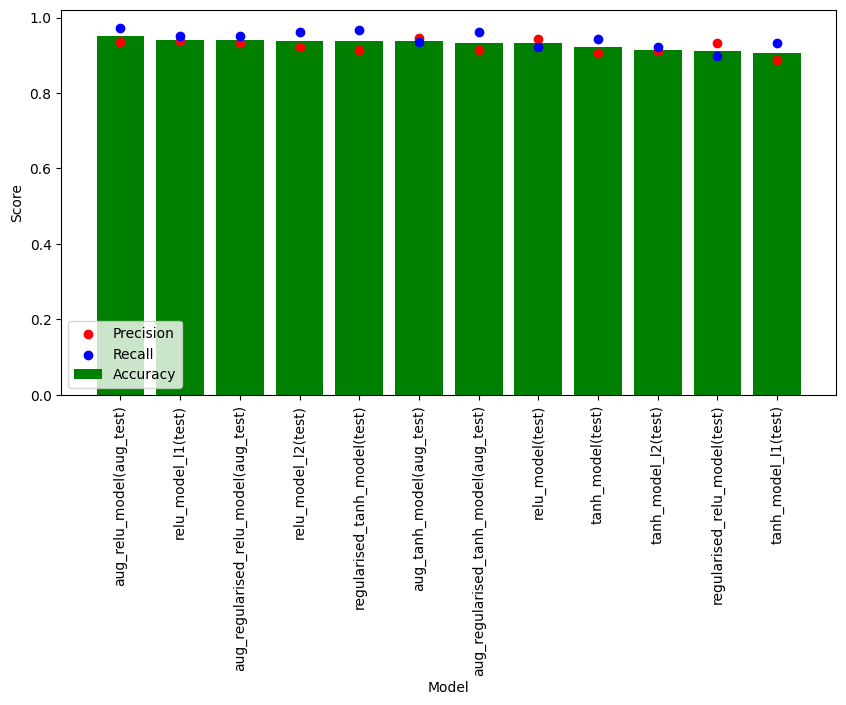

In [ ]:
df_sorted = df.sort_values(by="Accuracy", ascending=False)
df_sorted = df_sorted[(df_sorted.Dataset == "Test") | (df_sorted.Dataset == "Augmented Test")]
plt.figure(figsize=(10, 5))
# Plot accuracy, precision, recall
plt.bar(df_sorted["Model"], df_sorted["Accuracy"], color="green")
plt.scatter(df_sorted["Model"], df_sorted["Precision"], color="red")
plt.scatter(df_sorted["Model"], df_sorted["Recall"], color="blue")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend(["Precision", "Recall","Accuracy"])
plt.xticks(rotation=90)

plt.show()

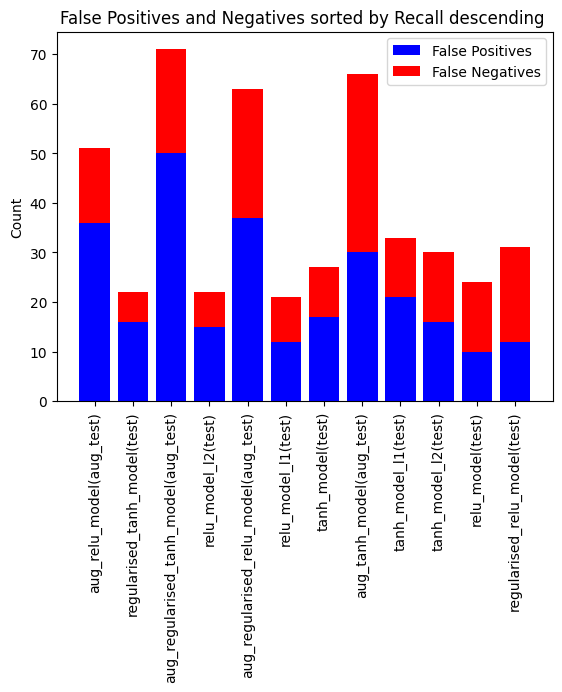

In [ ]:
# Plot results manually

# ax1, ax2 = plt.subplots(3,1, figsize=(10,10))

# ax1 = plt.subplot(2,1,1)
# ax2 = plt.subplot(2,1,2)

df_sorted = df.sort_values(by="Recall", ascending=False)
df_sorted = df_sorted[(df_sorted.Dataset == "Test") | (df_sorted.Dataset == "Augmented Test")]

for i in df_sorted['Model'].keys():
    # ax1.bar(df.loc[i, 'Model'], df.loc[i, 'True Pos'], color='b')
    # ax1.bar(df.loc[i, 'Model'], df.loc[i, 'True Neg'], bottom=df.loc[i, 'True Pos'], color='r')
    # ax1.set_ylabel('Count')
    # ax1.set_title('True Positives and Negatives')
    # ax1.legend(['True Positives', 'True Negatives'])
    # ax1.set_xticklabels([])

    plt.bar(df_sorted.loc[i, 'Model'], df_sorted.loc[i, 'False Pos'], color='b', label="FP")
    plt.bar(df_sorted.loc[i, 'Model'], df_sorted.loc[i, 'False Neg'], bottom=df_sorted.loc[i, 'False Pos'], color='r', label='FN')
    plt.legend(['False Positives', 'False Negatives'])
    plt.ylabel('Count')
    plt.title('False Positives and Negatives sorted by Recall descending ')

    plt.xticks(rotation=90)

plt.show()


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'aug_relu_model(aug_test)'),
  Text(1, 0, 'regularised_tanh_model(test)'),
  Text(2, 0, 'aug_regularised_tanh_model(aug_test)'),
  Text(3, 0, 'relu_model_l2(test)'),
  Text(4, 0, 'aug_regularised_relu_model(aug_test)'),
  Text(5, 0, 'relu_model_l1(test)'),
  Text(6, 0, 'tanh_model(test)'),
  Text(7, 0, 'aug_tanh_model(aug_test)'),
  Text(8, 0, 'tanh_model_l1(test)'),
  Text(9, 0, 'tanh_model_l2(test)'),
  Text(10, 0, 'relu_model(test)'),
  Text(11, 0, 'regularised_relu_model(test)')])

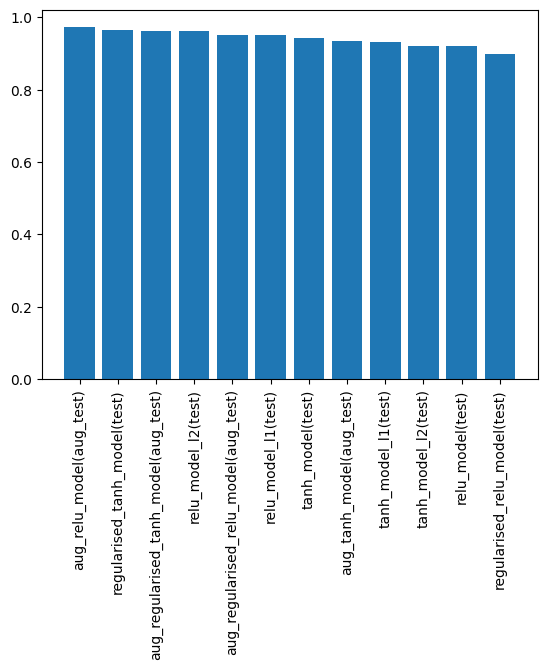

In [ ]:
plt.bar(df_sorted['Model'], df_sorted['Recall'])
plt.xticks(rotation=90)

In [ ]:
# ##### Balanced dataset

# # Relu and sigmoid

# correct, total, false_neg, false_pos = measure_accuracy(test_dataset, regularised_model)
# print("Prediction accuracy on test dataset (regularised relu): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(training_dataset, regularised_model)
# print("Prediction accuracy on training dataset (regularised relu): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# correct, total, false_neg, false_pos = measure_accuracy(test_dataset, relu_model)
# print("Prediction accuracy on test dataset (not-regularised relu): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(training_dataset, relu_model)
# print("Prediction accuracy on training dataset (not-regularised relu): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# # tanh and softmax

# correct, total, false_neg, false_pos = measure_accuracy(test_dataset, regularised_tanh_model)
# print("Prediction accuracy on test dataset (regularised tanh): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(training_dataset, regularised_tanh_model)
# print("Prediction accuracy on training dataset (regularised tanh): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# correct, total, false_neg, false_pos = measure_accuracy(test_dataset, tanh_model)
# print("Prediction accuracy on test dataset (not-regularised tanh): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(training_dataset, tanh_model)
# print("Prediction accuracy on training dataset (not-regularised tanh): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# ##### Augmented data

# print("####################################################")
# print("Augmented data:")
# print("####################################################")

# # Relu and sigmoid

# correct, total, false_neg, false_pos = measure_accuracy(aug_test_dataset, regularised_model)
# print("Prediction accuracy on test dataset (regularised relu augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(aug_training_dataset, regularised_model)
# print("Prediction accuracy on training dataset (regularised relu augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# correct, total, false_neg, false_pos = measure_accuracy(aug_test_dataset, relu_model)
# print("Prediction accuracy on test dataset (relu augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(aug_training_dataset, relu_model)
# print("Prediction accuracy on training dataset (relu augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# # tanh and softmax

# correct, total, false_neg, false_pos = measure_accuracy(aug_test_dataset, regularised_tanh_model)
# print("Prediction accuracy on test dataset (regularised tanh augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(aug_training_dataset, regularised_tanh_model)
# print("Prediction accuracy on training dataset (regularised tanh augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# correct, total, false_neg, false_pos = measure_accuracy(aug_test_dataset, tanh_model)
# print("Prediction accuracy on test dataset (tanh augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))
# correct, total, false_neg, false_pos = measure_accuracy(aug_training_dataset, tanh_model)
# print("Prediction accuracy on training dataset (tanh augmented): {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
# print("False Positives: {}, False Negatives: {}".format(false_pos, false_neg))

# # correct, total = measure_accuracy(all_data, regularised_model)
# # print("Prediction accuracy on all dataset: {} out of {} = {:.2f}%".format(correct, total, (100.0 * correct) / total ))
